## Score: 48

## Comment: 

<font color=Red>
Q1.[5+5+3] 1.3虽然代码中有质量控制的xch4_ppb_qc，但实际计算时使用的是整个时间序列
<br><br>
Q2.[10+10] Correct
<br><br>
Q3.[5+10] Correct
<br><br>
</font>

In [1]:
#PS3-1-0
import xarray as xr       # 处理 NetCDF
import numpy as np
import matplotlib.pyplot as plt

file_path = r"C:\Users\13530\Desktop\ACMRS\ESE5023\200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc"

# 打开文件
ds = xr.open_dataset(file_path)

# 查看数据
print(ds)

xch4_ppb = ds["xch4"] * 1e9   # 1 -> 1e9 ppb

# 纬度和经度
lat = ds["lat"]
lon = ds["lon"]

# 查看整个数据里甲烷的范围
vmin = float(xch4_ppb.min())
vmax = float(xch4_ppb.max())
print("XCH4 范围 (ppb):", vmin, " ~ ", vmax)

<xarray.Dataset> Size: 54MB
Dimensions:                  (time: 210, bnds: 2, lat: 36, lon: 72, pressure: 10)
Coordinates:
  * time                     (time) datetime64[ns] 2kB 2003-01-16T12:00:00 .....
  * lat                      (lat) float64 288B -87.5 -82.5 -77.5 ... 82.5 87.5
  * lon                      (lon) float64 576B -177.5 -172.5 ... 172.5 177.5
Dimensions without coordinates: bnds, pressure
Data variables:
    time_bnds                (time, bnds) datetime64[ns] 3kB ...
    lat_bnds                 (lat, bnds) float64 576B ...
    lon_bnds                 (lon, bnds) float64 1kB ...
    pre                      (pressure) float64 80B ...
    pre_bnds                 (pressure, bnds) float64 160B ...
    land_fraction            (lat, lon) float64 21kB ...
    xch4                     (time, lat, lon) float32 2MB ...
    xch4_nobs                (time, lat, lon) float64 4MB ...
    xch4_stderr              (time, lat, lon) float32 2MB ...
    xch4_stddev              (tim

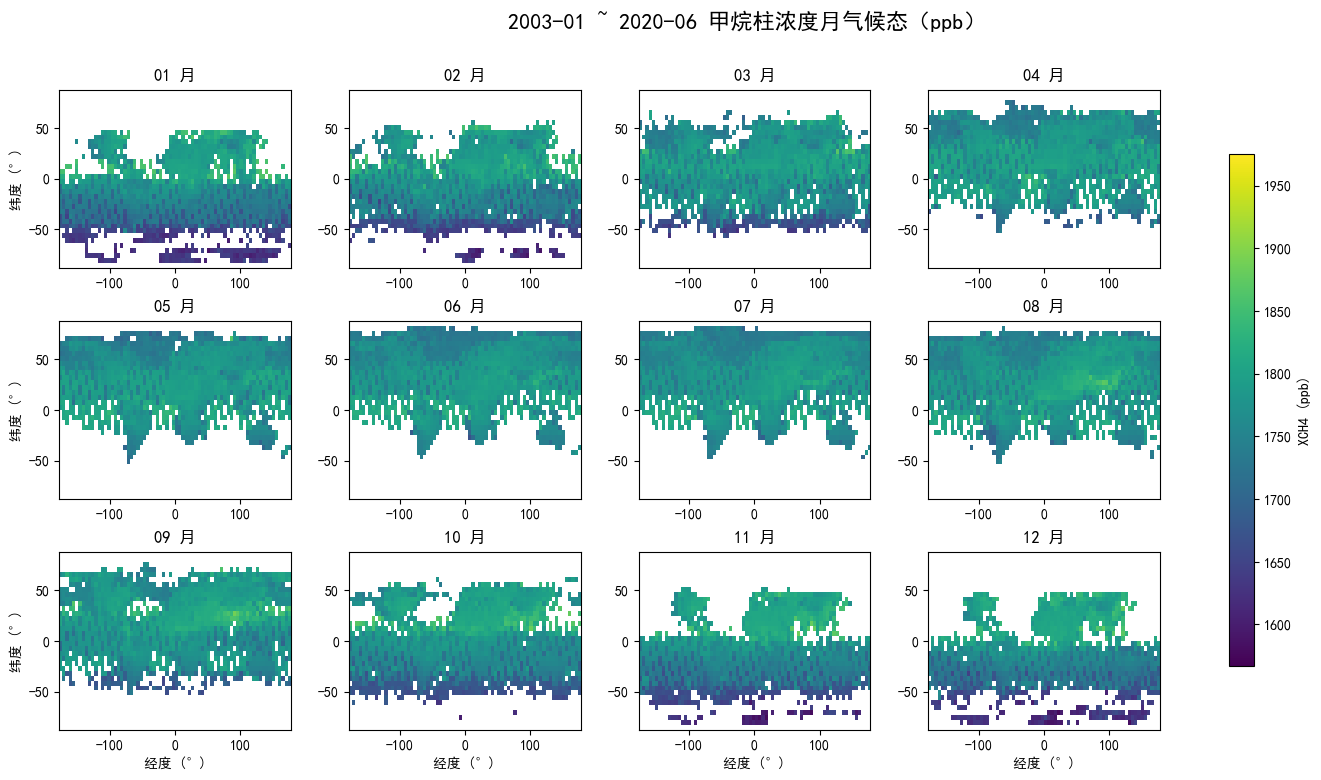

In [4]:
# PS3-1-1  计算每个月的气候态（climatology）

import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# 设置字体
matplotlib.rcParams["font.sans-serif"] = ["SimHei"]
# 解决坐标轴上负号显示成方块的问题
matplotlib.rcParams["axes.unicode_minus"] = False

# 读取文件
file_path = r"C:\Users\13530\Desktop\ACMRS\ESE5023\200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc"

# 打开文件
ds = xr.open_dataset(file_path)

# 单位换算成ppb
xch4_raw = ds["xch4"]
xch4_ppb = xch4_raw * 1e9

# 纬度、经度坐标
lat = ds["lat"]
lon = ds["lon"]


xch4_nobs   = ds["xch4_nobs"]        #   xch4_nobs ：该格点该月参与平均的观测条数
xch4_stderr = ds["xch4_stderr"]      #   xch4_stderr ：该格点该月柱平均甲烷的标准误差

# 条件 1：观测条数要求（要求 >= 10）——如果只有一两条观测就拿来算月平均，可信度比较低
cond_nobs = xch4_nobs >= 10

# 条件 2：标准误差不能太大——2e-8（大约对应 20 ppb 左右的误差）
cond_stderr = np.isfinite(xch4_stderr) & (xch4_stderr <= 2e-8)

# 上两个条件都满足才认为该格点该月“质量合格”
good_mask = cond_nobs & cond_stderr

# where：满足 good_mask 的地方保留原值——其余位置变成 NaN
xch4_ppb_qc = xch4_ppb.where(good_mask)

# 画图的颜色范围
vmin = float(xch4_ppb_qc.min())
vmax = float(xch4_ppb_qc.max())

# 计算月气候态（climatology）
# groupby("time.month") 按“月份（1~12）”分组
# 对每组在 time 上求平均，就得到：
#   对每个格点：所有年份 1 月的平均、2 月的平均、……12 月的平均
xch4_month_clim = xch4_ppb_qc.groupby("time.month").mean("time", skipna=True)

#  画12 个子图，展示各月气候态 
lon_min, lon_max = float(lon.min()), float(lon.max())
lat_min, lat_max = float(lat.min()), float(lat.max())

# 3 行 4 列子图
fig, axes = plt.subplots(3, 4, figsize=(16, 8))

for m in range(1, 13):
    # 取第 m 月的气候态场（二维：lat × lon）
    data_m = xch4_month_clim.sel(month=m)

    # 当前子图所在的行、列索引（从 0 开始）
    row = (m - 1) // 4
    col = (m - 1) % 4
    ax = axes[row, col]

    # 画出这一月的空间分布
    im = ax.imshow(
        data_m,
        origin="lower",  # 纬度从下往上增加，符合一般地图习惯
        extent=[lon_min, lon_max, lat_min, lat_max],
        vmin=vmin,       # 使用统一色标范围，方便月份之间比较
        vmax=vmax,
        aspect="auto"    # 自动调整纵横比，不强制方形
    )

    # 子图标题：显示“01 月”“02 月”……
    ax.set_title(f"{m:02d} 月")

    # 最下面一行的子图：加上经度标签
    if row == 2:
        ax.set_xlabel("经度 (°)")
    # 最左边一列的子图：加上纬度标签
    if col == 0:
        ax.set_ylabel("纬度 (°)")

# 设置整体标题 + 布局
left  = 0.06   # 左边多留点空白给 y 轴标签
right = 0.92   # 右边留出位置给颜色条
title_x = (left + right) / 2.0

# 整体大标题
fig.suptitle("2003-01 ~ 2020-06 甲烷柱浓度月气候态（ppb）",
             fontsize=16, x=title_x)

# 手动调整子图区域的位置，避免和标题、颜色条挤在一起
fig.subplots_adjust(
    left=left,
    right=right,
    bottom=0.08,
    top=0.88,
    wspace=0.25,   # 子图之间的水平间距
    hspace=0.30    # 子图之间的垂直间距
)

# 加一个公共颜色条，表示 XCH4 的数值范围
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
cbar.set_label("XCH4 (ppb)")

plt.show()


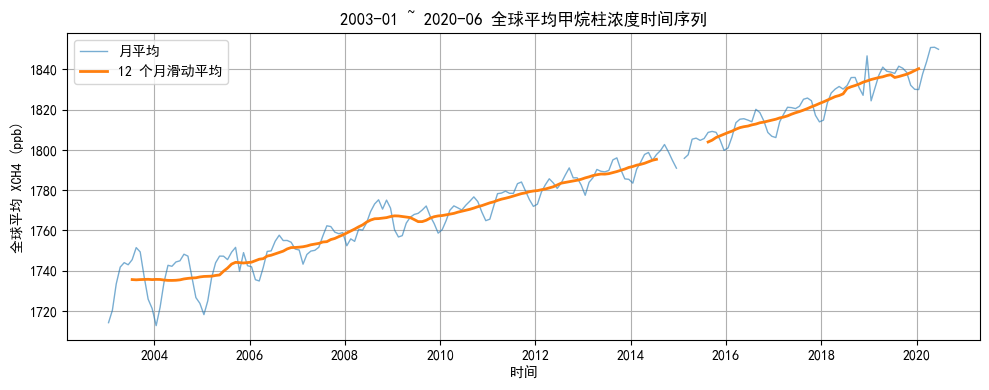

Result：总体趋势上，全球平均甲烷水平逐年上升，17年生生了140ppb左右；年度变化上，每个季度亦不相同，其中夏季相对较高，而冬季相对较低


In [21]:
# PS3-1-2  计算 2003-01 ~ 2020-06 全球平均甲烷并画时间序列

import numpy as np
import matplotlib.pyplot as plt

# 计算全球平均 XCH4 时间序列
# 先算出按纬度变化的权重：cos(phi)
lat_rad = np.deg2rad(lat)          # 把纬度从度转换成弧度
weights_lat = np.cos(lat_rad)      # 每条纬线的权重（1D，长度 = lat 维度）

#用 xarray 的 weighted 接口做加权平均
#    weighted(weights_lat) 会自动把纬向权重扩展到所有经度
#    然后在 (lat, lon) 方向上做平均，得到只随 time 变化的一维序列
global_mean_ts = xch4_ppb_qc.weighted(weights_lat).mean(("lat", "lon"))

# 再算一条 12 个月滑动平均，让曲线更平滑
#  rolling(time=12, center=True)：以 12 个月为窗口，在 time 维度上平滑
global_mean_smooth = global_mean_ts.rolling(time=12, center=True).mean()

#画时间序列 
plt.figure(figsize=(10, 4))

# 原始逐月时间序列（灰色细线）
plt.plot(ds["time"], global_mean_ts, linewidth=1.0, alpha=0.6, label="月平均")

# 12 个月滑动平均（蓝色粗线）
plt.plot(ds["time"], global_mean_smooth, linewidth=2.0, label="12 个月滑动平均")

plt.xlabel("时间")
plt.ylabel("全球平均 XCH4 (ppb)")
plt.title("2003-01 ~ 2020-06 全球平均甲烷柱浓度时间序列")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print("Result：总体趋势上，全球平均甲烷水平逐年上升，17年生生了140ppb左右；年度变化上，每个季度亦不相同，其中夏季相对较高，而冬季相对较低")

1.3 使用的格点坐标：lat = -12.5°, lon = -147.5°


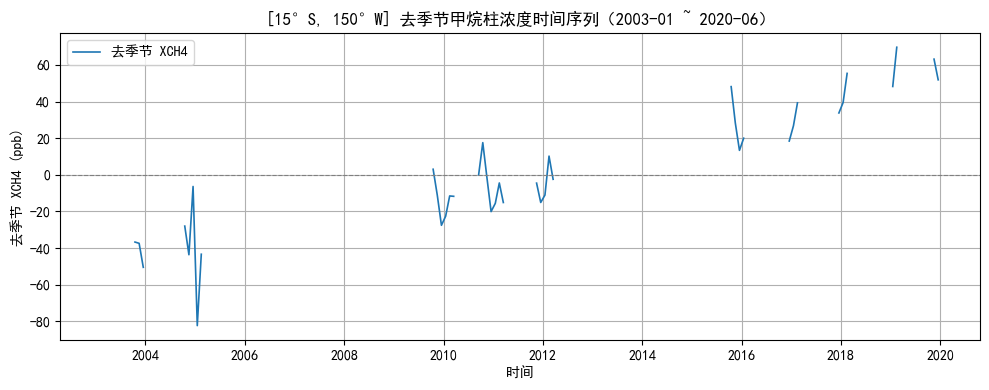

In [5]:
# PS3-1-3  [15°S, 150°W] 点的去季节甲烷时间序列

import numpy as np
import matplotlib.pyplot as plt

# 选取目标点附近的格点
# 在经纬度里：南纬用负号，西经也用负号
lat_target = -15.0   # 15°S
lon_target = -150.0  # 150°W

# 在“质量筛选后的数据”上选最接近目标点位的点
# method="nearest"：在 5°×5° 网格里选离目标坐标最近的那个格点
point_series = xch4_ppb_qc.sel(lat=lat_target, lon=lon_target, method="nearest")

# 如果筛选太严格，导致这个点在所有时间上都是 NaN，
# 就退一步，用未筛选的 xch4_ppb 来保证至少能画出一条曲线
if np.all(np.isnan(point_series.values)):
    point_series = xch4_ppb_qc.sel(lat=lat_target, lon=lon_target, method="nearest")

# 打印实际使用的格点坐标
print("1.3 使用的格点坐标：lat = %.1f°, lon = %.1f°"
      % (float(point_series.lat), float(point_series.lon)))


# 在该点上计算“月气候态”
# 思路：
#   把这个点 2003–2020 的时间序列按月份分组（所有 1 月、所有 2 月……）
#   对每一组求平均，就得到这个点“1 月的多年平均值”、“2 月的多年平均值”……
point_month_clim = point_series.groupby("time.month").mean("time", skipna=True)
# point_month_clim 只有 month 这个维度（1~12），是 12 个月的平均值


# 去季节处理
# 对每一个时间点：
#   去季节值 = 当月实测值 - 该点这个“月份”的多年平均值
point_deseason = point_series.groupby("time.month") - point_month_clim

# 画去季节后的时间序列
plt.figure(figsize=(10, 4))
plt.plot(ds["time"], point_deseason, linewidth=1.2, label="去季节 XCH4")

# 基线0：帮助判断是“高于多年平均”还是“低于多年平均”
plt.axhline(0.0, linestyle="--", linewidth=0.8, color="gray")

plt.xlabel("时间")
plt.ylabel("去季节 XCH4 (ppb)")
plt.title("[15°S, 150°W] 去季节甲烷柱浓度时间序列（2003-01 ~ 2020-06）")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
# PS3-2-1

import numpy as np
import xarray as xr

# 文件路径
file_path = r'C:\NOAA_NCDC_ERSST_v3b_SST.nc'

# 加载数据
ds = xr.open_dataset(file_path)

# 定义 Niño 3.4 区域的经纬度范围
lat_range = slice(-5, 5)   # 选择纬度从 5°S 到 5°N
lon_range = slice(190, 240)  # 经度从 170°W 到 120°W 转换为 190°E 到 240°E

# 从数据集中提取 Niño 3.4 区域的 SST 数据
sst_nino34 = ds['sst'].sel(lat=lat_range, lon=lon_range)

# 计算 Niño 3.4 区域的平均 SST
sst_nino34_timeseries = sst_nino34.mean(dim=['lat', 'lon'])  # 沿纬度和经度维度计算平均，得到时间序列数据

# 按月份计算月气候态 (Climatology)
monthly_climatology = sst_nino34_timeseries.groupby('time.month').mean(dim='time')

# 计算 SST 距平 (Anomalies)
sst_anomalies = sst_nino34_timeseries.groupby('time.month') - monthly_climatology

# 输出计算结果的前几行，确认没有 NaN
print("距平数据计算完成。前5个数据点：")
print(sst_anomalies.head())


距平数据计算完成。前5个数据点：
<xarray.DataArray 'sst' (time: 5)> Size: 20B
array([-0.31958008, -0.46852112, -0.26815224, -0.18696594, -0.17759895],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 40B 1960-01-15 1960-02-15 ... 1960-05-15
    month    (time) int64 40B 1 2 3 4 5


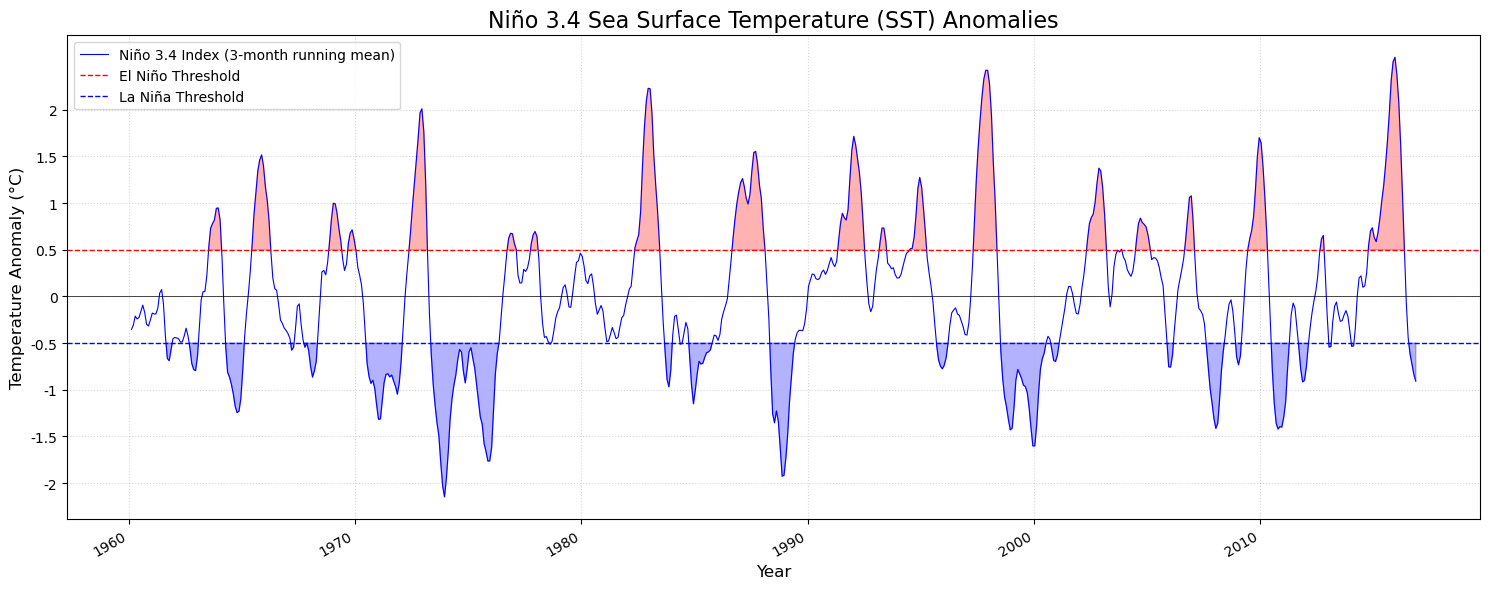

In [45]:
# PS3-2-2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

# 文件路径
file_path = r'C:\NOAA_NCDC_ERSST_v3b_SST.nc'

# 加载数据
ds = xr.open_dataset(file_path)

# 定义 Niño 3.4 区域的纬度和经度范围
lat_range = slice(-5, 5)   # 纬度从 5°S 到 5°N
lon_range = slice(190, 240)  # 经度从 170°W 到 120°W 转换为 190°E 到 240°E

# 提取海表温度数据
sst_nino34 = ds['sst'].sel(lat=lat_range, lon=lon_range)

# 计算区域的平均 SST 数据，得到时间序列
sst_nino34_timeseries = sst_nino34.mean(dim=['lat', 'lon'])

# 计算每月的气候态（即该月的平均温度）
monthly_climatology = sst_nino34_timeseries.groupby('time.month').mean(dim='time')

# 计算 SST 的异常值
sst_anomalies = sst_nino34_timeseries.groupby('time.month') - monthly_climatology

# 计算 3 个月的滑动平均，用于平滑数据
nino34_index = sst_anomalies.rolling(time=3, center=True).mean()

# 获取从 1950 年开始的数据
plot_data = nino34_index.sel(time=slice('1950-01-01', None))

# 创建图形
plt.figure(figsize=(15, 6))

# 绘制 Niño 3.4 指数的主曲线
plt.plot(plot_data['time'], plot_data, 
         label='Niño 3.4 Index (3-month running mean)', 
         color='blue', linewidth=0.8)

# 绘制阈值线（0°C, +0.5°C 和 -0.5°C）
plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
plt.axhline(0.5, color='red', linestyle='--', linewidth=1, label='El Niño Threshold')
plt.axhline(-0.5, color='blue', linestyle='--', linewidth=1, label='La Niña Threshold')

# 填充 El Niño的区域为红色
plt.fill_between(plot_data['time'], plot_data, 0.5, 
                 where=(plot_data >= 0.5), 
                 color='red', alpha=0.3, interpolate=True)

# 填充 La Niña 区域为蓝色
plt.fill_between(plot_data['time'], plot_data, -0.5, 
                 where=(plot_data <= -0.5), 
                 color='blue', alpha=0.3, interpolate=True)


# 设置标题、轴标签和图例
plt.title('Niño 3.4 Sea Surface Temperature (SST) Anomalies', fontsize=16)
plt.ylabel('Temperature Anomaly (°C)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.5)
plt.gcf().autofmt_xdate()

# 设置纵轴的刻度标签
plt.yticks(np.arange(-2, 2.5, 0.5), ['-2', '-1.5', '-1', '-0.5', '0', '0.5', '1', '1.5', '2'])

# 自动调整布局
plt.tight_layout()

# 显示图表
plt.show()


找到的文件：
   MERRA2_400.tavgM_2d_chm_Nx.202401.nc4
   MERRA2_400.tavgM_2d_chm_Nx.202402.nc4
   MERRA2_400.tavgM_2d_chm_Nx.202403.nc4
   MERRA2_400.tavgM_2d_chm_Nx.202404.nc4
   MERRA2_400.tavgM_2d_chm_Nx.202405.nc4
   MERRA2_400.tavgM_2d_chm_Nx.202406.nc4
   MERRA2_400.tavgM_2d_chm_Nx.202407.nc4
   MERRA2_400.tavgM_2d_chm_Nx.202408.nc4
   MERRA2_400.tavgM_2d_chm_Nx.202409.nc4
   MERRA2_400.tavgM_2d_chm_Nx.202410.nc4
   MERRA2_400.tavgM_2d_chm_Nx.202411.nc4
   MERRA2_400.tavgM_2d_chm_Nx.202412.nc4


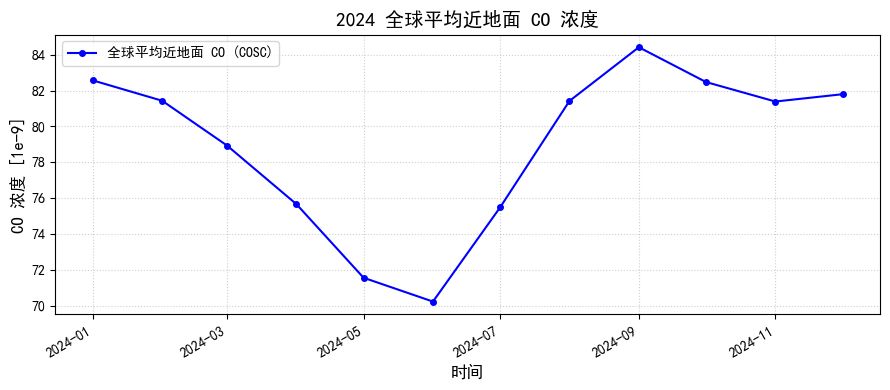

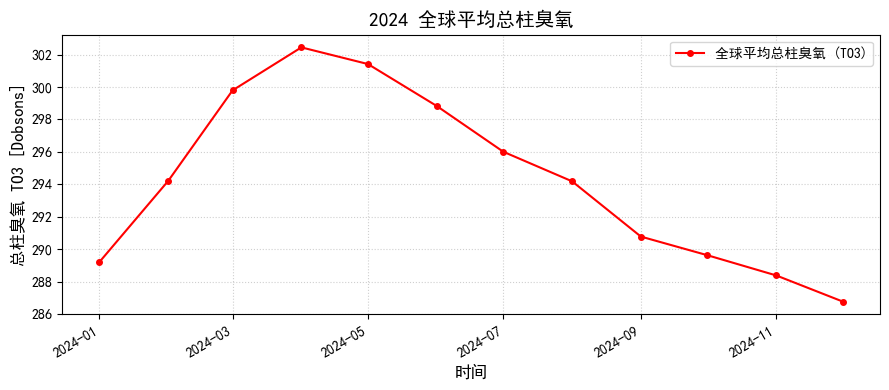

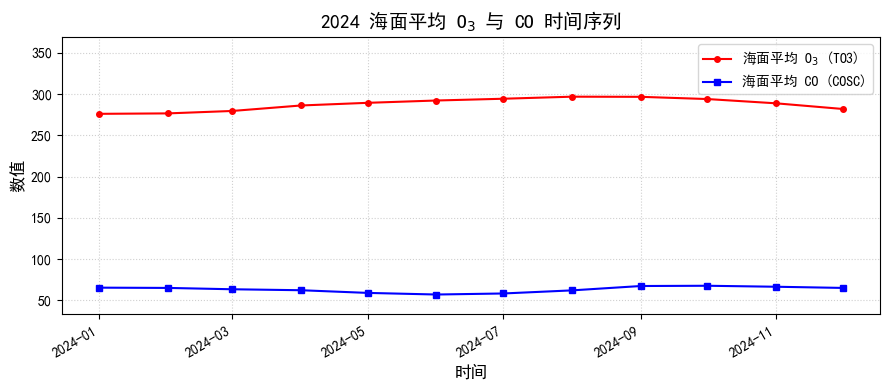

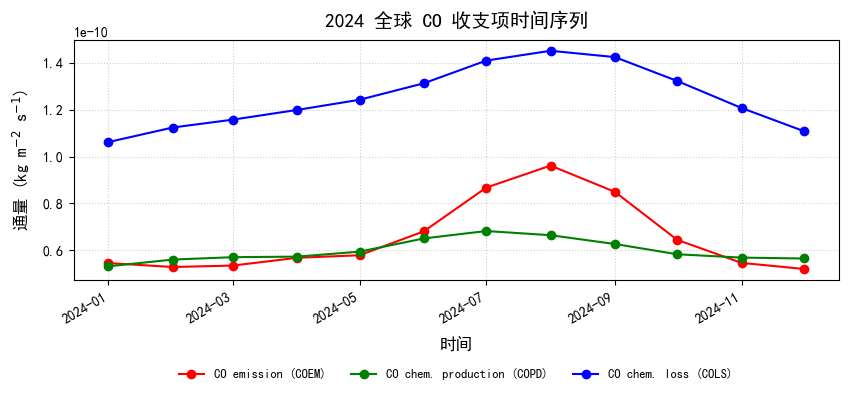

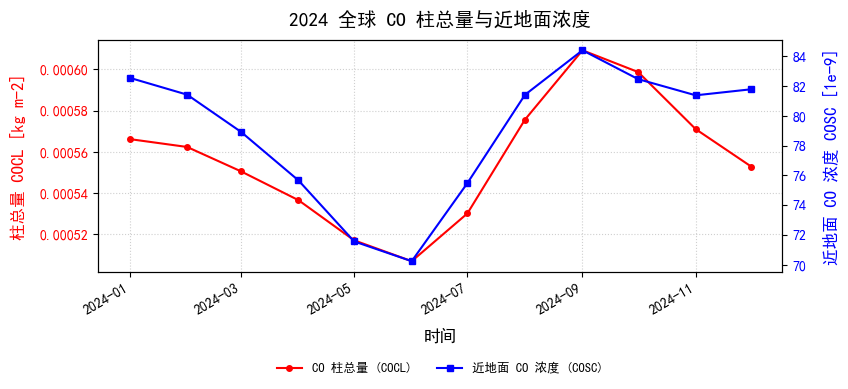

In [3]:
# PS3-3

#3  选择数据——含2024年大气CO、O3浓度、排放、消耗等信息的数据——按月共12个文件
import os
import glob
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams["font.sans-serif"] = ["SimHei"]
rcParams["axes.unicode_minus"] = False


# 读入 2024 年 12 个月数据
data_dir = r"C:\PS3"
file_pattern = os.path.join(data_dir, "MERRA2_400.tavgM_2d_chm_Nx.2024*.nc4")
file_list = sorted(glob.glob(file_pattern))

print("找到的文件：")
for f in file_list:
    print("  ", os.path.basename(f))

ds = xr.open_mfdataset(
    file_list,
    combine="by_coords",
    engine="netcdf4",
)


# 提取变量
to3  = ds["TO3"]    # 总柱臭氧
cosc = ds["COSC"]   # 近地面 CO 浓度
lwi  = ds["LWI"]    # 陆地/水面/冰标志：0=水, 1=陆地, 2=冰

# CO 收支相关变量
coem = ds["COEM"]   # CO 排放
copd = ds["COPD"]   # CO 化学生成
cols = ds["COLS"]   # CO 化学损失
cocl = ds["COCL"]   # CO 柱总量

lwi0 = lwi.isel(time=0)

# 按 cos(纬度) 做面积权重
lat = ds["lat"]
weights_lat = np.cos(np.deg2rad(lat))

# 扩展成 (lat, lon)
weights_2d = xr.DataArray(
    weights_lat,
    dims=["lat"]
).broadcast_like(to3.isel(time=0))


def area_mean(var, mask=None):
    """
    var : (time, lat, lon)
    mask: (lat, lon) 布尔掩膜，True 为保留区域；None 表示全球
    """
    w = weights_2d.copy()
    if mask is not None:
        w   = w.where(mask)
        var = var.where(mask)

    num = (var * w).sum(dim=("lat", "lon"))
    den = w.sum(dim=("lat", "lon"))
    mean = xr.where(den > 0, num / den, np.nan)
    return mean


def ts_global(var, mask=None):
    """返回 pandas.Series 形式的全球/区域平均时间序列"""
    return area_mean(var, mask).compute().to_series()


#计算含时间序列的信息

# 全球平均 O3 & CO
to3_global_ts  = ts_global(to3)
cosc_global_ts = ts_global(cosc)

# 海面掩膜（LWI = 0）
mask_ocean = (lwi0 == 0)

# 海面平均 O3 & CO
to3_ocean_ts  = ts_global(to3,  mask_ocean)
cosc_ocean_ts = ts_global(cosc, mask_ocean)

# CO 收支三项（全球平均）
coem_ts = ts_global(coem)   # emission
copd_ts = ts_global(copd)   # chem. production
cols_ts = ts_global(cols)   # chem. loss

# CO 柱总量（全球平均）
cocl_ts = ts_global(cocl)   # column burden


#图 1：全球近地面 CO 的月度变化（2024）
plt.figure(figsize=(9, 4))
plt.plot(cosc_global_ts.index, cosc_global_ts.values,
         "b-o", linewidth=1.5, markersize=4,
         label="全球平均近地面 CO (COSC)")

plt.title("2024 全球平均近地面 CO 浓度", fontsize=14)
plt.xlabel("时间", fontsize=12)
plt.ylabel(f"CO 浓度 [{cosc.attrs.get('units', 'ppbv')}]", fontsize=12)
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(loc="best")
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

#图2：全球总柱臭氧的月度变化（2024）
plt.figure(figsize=(9, 4))
plt.plot(to3_global_ts.index, to3_global_ts.values,
         "r-o", linewidth=1.5, markersize=4,
         label="全球平均总柱臭氧 (TO3)")

plt.title("2024 全球平均总柱臭氧", fontsize=14)
plt.xlabel("时间", fontsize=12)
plt.ylabel(f"总柱臭氧 TO3 [{to3.attrs.get('units', 'DU')}]", fontsize=12)
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(loc="best")
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


#  图 3：海面 O3 和 CO 月度变化 （2024）
plt.figure(figsize=(9, 4))

plt.plot(to3_ocean_ts.index, to3_ocean_ts.values,
         "r-o", linewidth=1.5, markersize=4,
         label="海面平均 O$_3$ (TO3)")
plt.plot(cosc_ocean_ts.index, cosc_ocean_ts.values,
         "b-s", linewidth=1.5, markersize=4,
         label="海面平均 CO (COSC)")

plt.title("2024 海面平均 O$_3$ 与 CO 时间序列", fontsize=14)
plt.xlabel("时间", fontsize=12)
plt.ylabel("数值", fontsize=12)  

# 给 y 轴留点空间，避免和图例重叠
y_min = min(to3_ocean_ts.min(), cosc_ocean_ts.min())
y_max = max(to3_ocean_ts.max(), cosc_ocean_ts.max())
y_range = y_max - y_min
plt.ylim(y_min - 0.1 * y_range, y_max + 0.3 * y_range)

plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(loc="upper right")
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


# 图 4：CO 收支三项的阅读变化（2024）
fig, ax = plt.subplots(figsize=(9, 4))

ax.plot(coem_ts.index, coem_ts.values, "r-o", label="CO emission (COEM)")
ax.plot(copd_ts.index, copd_ts.values, "g-o", label="CO chem. production (COPD)")
ax.plot(cols_ts.index, cols_ts.values, "b-o", label="CO chem. loss (COLS)")

ax.set_title("2024 全球 CO 收支项时间序列", fontsize=14, pad=10)
ax.set_xlabel("时间", fontsize=12, labelpad=8)
ax.set_ylabel("通量 (kg m$^{-2}$ s$^{-1}$)", fontsize=12, labelpad=8)
ax.grid(True, linestyle=":", alpha=0.6)

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.32),
    ncol=3,
    frameon=False,
    fontsize=9,
)

fig.autofmt_xdate()
fig.subplots_adjust(left=0.1, right=0.95, top=0.88, bottom=0.28)
plt.show()


# 图 5：CO 柱总量 vs 近地面浓度
fig, ax1 = plt.subplots(figsize=(9, 4))

# 左轴：CO 柱总量
ln1 = ax1.plot(
    cocl_ts.index, cocl_ts.values,
    "r-o", linewidth=1.5, markersize=4,
    label="CO 柱总量 (COCL)",
)
ax1.set_xlabel("时间", fontsize=12, labelpad=8)
ax1.set_ylabel(
    f"柱总量 COCL [{cocl.attrs.get('units', 'kg m$^{-2}$')}]",
    fontsize=12, color="r", labelpad=10,
)
ax1.tick_params(axis="y", labelcolor="r")
ax1.grid(True, linestyle=":", alpha=0.6)

# 右轴：近地面 CO 浓度
ax2 = ax1.twinx()
ln2 = ax2.plot(
    cosc_global_ts.index, cosc_global_ts.values,
    "b-s", linewidth=1.5, markersize=4,
    label="近地面 CO 浓度 (COSC)",
)
ax2.set_ylabel(
    f"近地面 CO 浓度 COSC [{cosc.attrs.get('units', 'ppbv')}]",
    fontsize=12, color="b", labelpad=12,
)
ax2.tick_params(axis="y", labelcolor="b")

# 合并图例
lines  = ln1 + ln2
labels = [l.get_label() for l in lines]
ax1.legend(
    lines, labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.34),
    ncol=2,
    frameon=False,
    fontsize=9,
)

ax1.set_title("2024 全球 CO 柱总量与近地面浓度", fontsize=14, pad=10)
fig.autofmt_xdate()
fig.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.30)
plt.show()

